In [0]:
%pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=fb671a091a96e09a4fab1b5c9052bda2c593e8908d69de13726020f3da52854b
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, contextlib, sys
#rom loaddata import loaddata
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import quantile_transform
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold


In [0]:
%cd /content/drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
np.random.seed(seed=1)

In [0]:
gpu = torch.device("cuda:0")

In [0]:
def loaddata(directory):
    feature_list = list()
    train_data_list = list()
    train_target_list = list()
    for i,filename in enumerate(os.listdir(directory)):
        raw_data = np.genfromtxt(f'{directory}/{filename}', delimiter=',', names=True)
        data_matrix = np.genfromtxt(f'{directory}/{filename}', delimiter=',',skip_header=1)
        
        if i==0: 
            feature_list.append(raw_data.dtype.names)
            train_data_list.append(data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]])
            train_target_list.append(data_matrix[:,1])
        elif i==len(os.listdir(directory))-1:
            test_data = data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]]
            test_target = data_matrix[:,1]
        else:
            train_data_list.append(data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]])
            train_target_list.append(data_matrix[:,1])
    #train_data_list = np.vstack((train_data_list))
    #train_target_list =  np.concatenate(train_target_list)
    return train_data_list, train_target_list, test_data, test_target

def get_explained(model, data, target):
    model.eval()
    pred = model(data).squeeze().detach().numpy()
    target = target.detach().numpy()

    return explained_variance_score(target, pred), r2_score(target, pred)

In [0]:
class LSTMTagger(nn.Module):

    def __init__(self, inputsize, layers, hiddensize, drop_out):
        super(LSTMTagger, self).__init__()
        self.inputsize = inputsize
        self.hiddensize = hiddensize
        self.layers = layers
        self.drop_out = drop_out

        self.lstm = nn.LSTM(input_size=self.inputsize, hidden_size = self.hiddensize, num_layers=layers, dropout=drop_out,batch_first=True)
        self.hidden2radial = nn.Linear(in_features=hiddensize, out_features=1)

    def forward(self, x):
        x, _ = self.lstm(x)
        #x = F.relu(x)
        x = self.hidden2radial(x)
        return x

In [0]:
def crossval(n_epochs,layers,hiddensize,drop_out, lr):
    criterion = nn.MSELoss()
    judge = list()
    for i,valdata in enumerate(train_data_torch):
          model = LSTMTagger(27,layers=layers, hiddensize=hiddensize,drop_out=drop_out).to(gpu)
          optimizer = optim.Adam(model.parameters(),lr=lr)

          traindata = train_data_torch[:i] + train_data_torch[i+1:]
          traintarget = train_target_torch[:i] + train_target_torch[i+1:]
          valtarget = train_target_torch[i]
          judge_list = list()
          for e in range(n_epochs):
              model.train()
              epoch_losses = list()
              epoch_evs = list()
              acc_list = list()
              loss_list = list()
              for batch in range(len(traindata)):
                  model.zero_grad()
                  optimizer.zero_grad() 
                  prediction = model(traindata[batch])
                  target = traintarget[batch]
                  # Calculating the loss function
                  loss = criterion(prediction.squeeze(dim=2), target)
                  # Calculating the gradient
                  loss.backward()
                  optimizer.step()
              with torch.no_grad():
                  model.eval()
                  train_prediction = model(valdata).squeeze(dim=1)
                  loss_list.append( float(criterion((train_prediction),valtarget).detach().cpu()) )
                  acc_list.append( explained_variance_score(valtarget.cpu(), train_prediction.cpu()) )
              print(e, np.mean(loss_list),np.mean(acc_list))
              judge_list.append(np.mean(acc_list))
          judge.append([np.mean(judge_list),model])
    sorted(judge, key=lambda x: x[0])
    winner = judge[0]
    return winner[1]

In [0]:
def allval(n_epochs,layers,hiddensize,drop_out, lr,weightd):
    criterion = nn.MSELoss()
    model = LSTMTagger(27,layers=layers, hiddensize=hiddensize,drop_out=drop_out).to(gpu)
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weightd)

    traindata = train_data_torch
    traintarget = train_target_torch

    model.train()
    for e in range(n_epochs):
        epoch_losses = list()
        epoch_evs = list()
        acc_list = list()
        loss_list = list()
        for batch in range(len(traindata)):
            model.zero_grad()
            optimizer.zero_grad() 
            prediction = model(traindata[batch])
            target = traintarget[batch]
            # Calculating the loss function
            loss = criterion(prediction.squeeze(dim=2), target)
            epoch_losses.append(float(loss))
            evs = explained_variance_score(target.squeeze(dim=1).detach().cpu().numpy(),prediction.squeeze(dim=1).detach().cpu().numpy())
            epoch_evs.append(evs)
            # Calculating the gradient
            loss.backward()
            optimizer.step()

        print(e, np.mean(epoch_losses),np.mean(epoch_evs))
    return model

In [0]:
train_data_list, train_target_list, test_data, test_target = loaddata('data')

In [0]:
train_data_list = [quantile_transform(data,n_quantiles=100,copy=True) for data in train_data_list]
test_data = quantile_transform(test_data,n_quantiles=100,copy=True)

In [0]:
train_data_torch = [torch.from_numpy(data).unsqueeze(dim=1).float().to(gpu) for data in train_data_list]
train_target_torch = [torch.from_numpy(data).unsqueeze(dim=1).float().to(gpu) for data in train_target_list]
test_data_torch, test_target_torch = torch.from_numpy(np.array(test_data)).unsqueeze(dim=1).float().to(gpu), torch.from_numpy(np.array(test_target)).float().to(gpu)

In [0]:
model = allval(10000,layers=2,hiddensize=50,drop_out=0.9, lr=0.0001, weightd=4e-3)

Streaming output truncated to the last 5000 lines.
5001 8884.123331705729 -0.02926403284072876
5002 8933.501017252604 -0.040270467599232994
5003 8882.81982421875 -0.02749466896057129
5004 8950.063802083334 -0.04008313020070394
5005 8942.357177734375 -0.0297964612642924
5006 8917.984212239584 -0.027865827083587646
5007 9024.878621419271 -0.04521928230921427
5008 8952.426839192709 -0.03541034460067749
5009 8909.421223958334 -0.03834007183710734
5010 9037.491902669271 -0.043476263682047524
5011 9014.448933919271 -0.053921679655710854
5012 8959.021036783854 -0.033685525258382164
5013 8943.561238606771 -0.014442582925160726
5014 8945.97021484375 -0.046517789363861084
5015 8859.397827148438 -0.00743788480758667
5016 9057.566324869791 -0.03789389133453369
5017 9050.941446940104 -0.05945473909378052
5018 9024.195760091146 -0.05671091874440511
5019 8959.505533854166 -0.04539199670155843
5020 8890.458211263021 -0.035379926363627114
5021 8995.525634765625 -0.027021348476409912
5022 8889.742268880

In [0]:
def plot(test,number=0):
    if test == True:
      time = test_data[:,0]
      title = 'Test data'
      data_plot = test_data_torch
      RV_true = test_target_torch.cpu().numpy()
    elif test == False:
      title = f'Train data {number}'
      data_plot = train_data_torch[number]
      time = train_data_list[number]
      time = time[:,0]
      RV_true = train_target_torch[number].cpu().numpy()
    RV_pred = model(data_plot).squeeze(dim=2).detach().cpu().numpy()
    print( explained_variance_score(RV_true,RV_pred) )
    plt.title('Test data')
    plt.plot(time,RV_pred,'r-',label='Predicted')
    plt.plot(time,RV_true, 'k-', label='True')
    plt.legend()
    plt.show()

0.5793427228927612


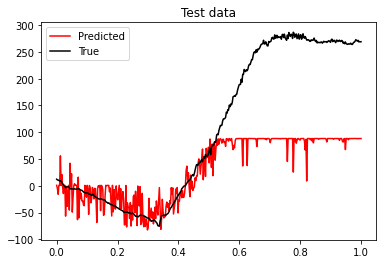

0.46441179513931274


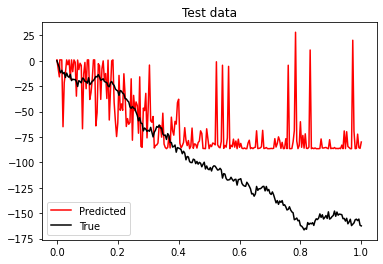

-0.27974724769592285


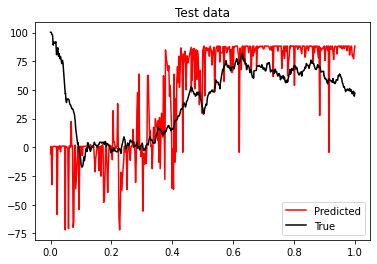

-6.251267433166504


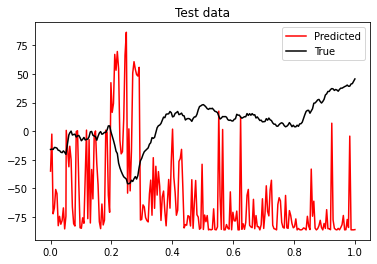

In [0]:
for i in range(3):
  plot(False,i)
plot(True)